# Police Dataset 🚨👮🏻‍♀️🚔🚨

### What do we want to extract from this data?

Questions to Answer:

1. Does the outcomes of the police stop reflects appropriate penalties for the given violation?
2. Does the police have any bias towards any group?

## Extração de Dados - Parte 1

In [2]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

In [3]:
csv_path = "../data/police.csv"
df = pd.read_csv(csv_path)
df.fillna("NA")
df.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [4]:
df.search_type = df.search_type.fillna("none")
df.search_type.unique()

array(['none', 'Incident to Arrest,Protective Frisk', 'Probable Cause',
       'Incident to Arrest', 'Probable Cause,Reasonable Suspicion',
       'Incident to Arrest,Inventory,Probable Cause',
       'Incident to Arrest,Inventory',
       'Incident to Arrest,Probable Cause', 'Protective Frisk',
       'Reasonable Suspicion', 'Inventory', 'Inventory,Protective Frisk',
       'Incident to Arrest,Reasonable Suspicion',
       'Incident to Arrest,Probable Cause,Protective Frisk',
       'Probable Cause,Protective Frisk',
       'Incident to Arrest,Inventory,Protective Frisk',
       'Protective Frisk,Reasonable Suspicion',
       'Incident to Arrest,Inventory,Reasonable Suspicion',
       'Inventory,Probable Cause',
       'Incident to Arrest,Protective Frisk,Reasonable Suspicion',
       'Inventory,Probable Cause,Protective Frisk',
       'Inventory,Reasonable Suspicion',
       'Incident to Arrest,Probable Cause,Reasonable Suspicion',
       'Inventory,Probable Cause,Reasonable Suspicio

In [5]:
display(df.describe())
display(df.describe(include="O"))

,county_name,driver_age_raw,driver_age
count,0.0,86414.000000,86120.000000
mean,NaN,1970.491228,34.011333
std,NaN,110.914909,12.738564
min,NaN,0.000000,15.000000
25%,NaN,1967.000000,23.000000
50%,NaN,1980.000000,31.000000
75%,NaN,1987.000000,43.000000
max,NaN,8801.000000,99.000000


,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_type,stop_outcome,is_arrested,stop_duration
count,91741,91741,86406,86408,86408,86408,91741,86408,86408,86408
unique,3768,1436,2,5,12,6,25,6,2,5
top,2012-01-11,11:00,M,White,Speeding,Speeding,none,Citation,False,0-15 Min
freq,69,323,62895,62158,48463,48463,88545,77006,83479,69543


In [6]:
df.search_type.value_counts(dropna=False)

search_type
none                                                        88545
Incident to Arrest                                           1219
Probable Cause                                                891
Inventory                                                     220
Reasonable Suspicion                                          197
Protective Frisk                                              161
Incident to Arrest,Inventory                                  129
Incident to Arrest,Probable Cause                             106
Probable Cause,Reasonable Suspicion                            75
Incident to Arrest,Inventory,Probable Cause                    34
Probable Cause,Protective Frisk                                33
Incident to Arrest,Protective Frisk                            33
Inventory,Probable Cause                                       22
Incident to Arrest,Reasonable Suspicion                        13
Incident to Arrest,Inventory,Protective Frisk                  1

In [45]:
display(df.search_type.dropna().apply(lambda x: x.split(",")).explode().value_counts())

all_search_types = df.search_type.dropna().apply(lambda x: x.split(",")).explode().unique().tolist()
all_search_types.remove("none")

search_type
none                    88545
Incident to Arrest       1566
Probable Cause           1182
Inventory                 439
Reasonable Suspicion      314
Protective Frisk          274
Name: count, dtype: int64

In [8]:
print("Violations:")
print(df.violation.unique())
print("Stop Outcomes:")
print(df.stop_outcome.unique())
print("Stop Durations:")
print(df.stop_duration.unique())
print("Search Conducted:")
print(df.search_conducted.unique())

Violations:
['Speeding' 'Other' 'Equipment' 'Moving violation' nan
 'Registration/plates' 'Seat belt']
Stop Outcomes:
['Citation' 'Arrest Driver' nan 'N/D' 'Warning' 'Arrest Passenger'
 'No Action']
Stop Durations:
['0-15 Min' '16-30 Min' '30+ Min' nan '2' '1']
Search Conducted:
[False  True]


In [9]:
# Treating Nulls

cleaned_df = df.copy()

# TODO: Apply PMM
cleaned_df["driver_age"] = cleaned_df.driver_age.fillna(0.0)
cleaned_df["is_arrested"] = cleaned_df.is_arrested.fillna(False)

## Limpeza | Transformação | Análise Exploratória - Parte 2 ⚙️ 

In [10]:
"""
Essa parte do código trata a discretização das features `stop_outcome`, `violation` e `stop_time`.
"""

def stop_outcome_level(row):
    """
    stop_outcome_level - creates a feature that qantifies the gravity level of the
    stop outcome. The higher the level means worse outcome.
    Will follow the rule:
    5. Arrest Driver
    4. Arrest Passenger
    3. Citation
    2. Warning
    1. N/D | No Action | any other
    """
    stop_outcome_level = 1
    if row.stop_outcome == "Arrest Driver":
        stop_outcome_level = 5
    elif row.stop_outcome == "Arrest Passenger":
        stop_outcome_level = 4
    elif row.stop_outcome == "Citation":
        stop_outcome_level = 3
    elif row.stop_outcome == "Warning":
        stop_outcome_level = 2

    return stop_outcome_level


def violation_level(row):
    """
    violation_level - creates a feature that quantifies the gravity level of the
    violation commited. The higher the level means worse violation.
    Will follow the rule:
    5. Speeding
    4. Moving Violation
    3. Seat Belt
    2. Registration/plates
    1. any other
    """
    violation_level = 1
    if row.violation == "Speeding":
        violation_level = 5
    elif row.violation == "Moving Violation":
        violation_level = 4
    elif row.violation == "Seat Belt":
        violation_level = 3
    elif row.violation == "Registration/plates":
        violation_level = 2

    return violation_level


def stop_time_discretization(row):
    """
    stop_time_discretization - quantifies hour
    """
    hour_min = row.stop_time.split(":")
    stop_time_discrete = int(hour_min[0] + hour_min[1])
    return stop_time_discrete

In [11]:
featured_df = cleaned_df.copy()
featured_df["stop_outcome_level"] = featured_df.apply(
    stop_outcome_level, axis="columns"
)
featured_df["violation_level"] = featured_df.apply(violation_level, axis="columns")
"""
proportinal_stop_outcome: measures the proportion of the outcome level with the violation level
pso = 1: equaly proportional
pso > 1: disproportionally greater
pso < 1: disproportionally lower
"""
featured_df["proportional_stop_outcome"] = (
    featured_df["stop_outcome_level"] / featured_df["violation_level"]
)
featured_df["stop_time_discrete"] = featured_df.apply(
    stop_time_discretization, axis="columns"
)
"""
is_black_or_hispanic - agrupamento de grupos que históricamente sofrem mais com abordagens policiais
"""
featured_df["is_black_or_hispanic"] = featured_df.apply(
    lambda row: row.driver_race == "Black" or row.driver_race == "Hispanic",
    axis="columns",
)

featured_df["stop_time_discrete_bins"] = pd.cut(
    featured_df["stop_time_discrete"], 4, labels=["dawn", "morning", "evening", "night"]
)
"""
driver_age_bins - discretiza o 'driver age' em 4 bins:
"""
featured_df["driver_age_bins"] = pd.cut(
    featured_df["driver_age"], 4, labels=["jovem", "adulto", "meia_idade", "idoso"]
)

"""
counter - column to make counting operations easier
"""
featured_df["counter"] = 1

featured_df.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,...,stop_duration,drugs_related_stop,stop_outcome_level,violation_level,proportional_stop_outcome,stop_time_discrete,is_black_or_hispanic,stop_time_discrete_bins,driver_age_bins,counter
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,155,False,dawn,jovem,1
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,815,False,morning,adulto,1
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,2315,False,night,adulto,1
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,...,16-30 Min,False,5,1,5.0,1715,False,evening,jovem,1
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,1000,False,morning,jovem,1


In [56]:
search_type_features = [
    "is_arrested",
    "driver_race",
    "driver_gender",
    "stop_outcome_level",
    "violation_level",
    "search_conducted",
    "search_type",
    "drugs_related_stop",
    "driver_age_bins",
    "is_black_or_hispanic",
]
search_type_df = featured_df.copy()
search_type_df = search_type_df[search_type_features]

"""
Criação de atributos no estilo 'one-hot encoder' para a feature `search_type`
"""
for s_type in all_search_types:
    col_name = s_type.replace(" ", "_").lower()
    search_type_df[col_name] = search_type_df.search_type.str.contains(s_type).astype(int)
    
search_type_df.head()

,is_arrested,driver_race,driver_gender,stop_outcome_level,violation_level,search_conducted,search_type,drugs_related_stop,driver_age_bins,is_black_or_hispanic,incident_to_arrest,protective_frisk,probable_cause,reasonable_suspicion,inventory
40,True,White,M,5,1,True,Probable Cause,True,jovem,False,0,0,1,0,0
41,False,White,M,3,1,True,Probable Cause,True,jovem,False,0,0,1,0,0
106,False,Black,M,3,1,True,Probable Cause,False,adulto,True,0,0,1,0,0
139,True,Black,M,5,1,True,"Probable Cause,Reasonable Suspicion",True,adulto,True,0,0,1,1,0
163,False,Black,M,1,1,True,"Incident to Arrest,Inventory,Probable Cause",False,adulto,True,1,0,1,0,1


## Simple Exploratory Analysis 🗺️

### Conclusions 📝

* There is almost 3 times more men than women stopped by police. This might no be an inbalance, but rather an tendency.
* The most recurrent age rance is from 33 to 40. This also might not be an inbalance, but rather an tendency as well. 
* The most stopped race is White.

In [12]:
featured_df.groupby("driver_gender").describe()

county_name                              driver_age_raw  \
                    count mean std min 25% 50% 75% max          count   
driver_gender                                                           
F                     0.0  NaN NaN NaN NaN NaN NaN NaN        23510.0   
M                     0.0  NaN NaN NaN NaN NaN NaN NaN        62895.0   

                            ... stop_time_discrete          counter            \
                      mean  ...                75%     max    count mean  std   
driver_gender               ...                                                 
F              1974.766610  ...             1620.0  2359.0  23511.0  1.0  0.0   
M              1968.954718  ...             1639.0  2359.0  62895.0  1.0  0.0   

                                        
               min  25%  50%  75%  max  
driver_gender                           
F              1.0  1.0  1.0  1.0  1.0  
M              1.0  1.0  1.0  1.0  1.0  

[2 rows x 64 columns]

<Axes: xlabel='driver_race'>

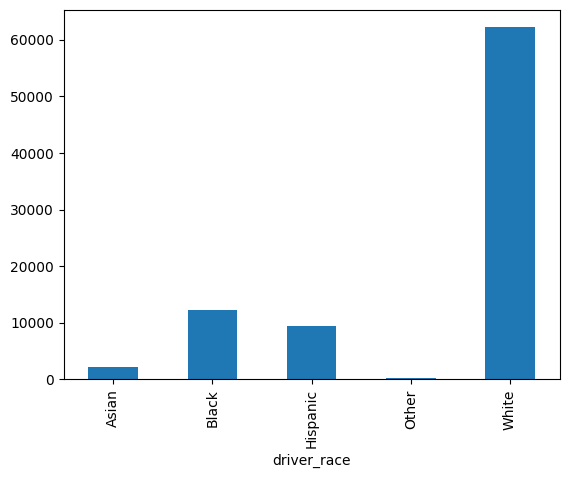

In [13]:
featured_df.groupby("driver_race")["counter"].count().plot(kind="bar")

<Axes: ylabel='Frequency'>

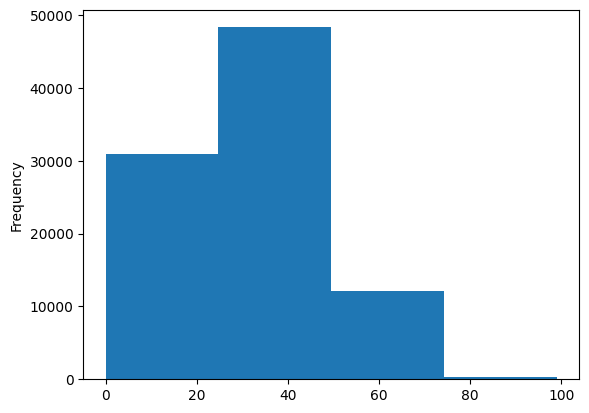

In [14]:
featured_df.driver_age.plot.hist(bins=4)

### Conclusions 📝

The profile of most arrested individuals are represented by the following:
* adult 
* white 
* men

If you are black or hispanic you are two times more likely to be arrested than white and asian people.

In [15]:
featured_df_cp = featured_df.copy()
featured_df_cp["driver_race"] = featured_df.driver_race.fillna("NA")

arrest_proportional_per_race = {}

for race in featured_df_cp["driver_race"].unique():
    arrest_proportional_per_race[race] = (
        featured_df_cp[
            (featured_df_cp.is_arrested == True) & (featured_df_cp.driver_race == race)
        ].shape[0]
        / featured_df_cp[featured_df_cp.driver_race == race].shape[0]
    ) * 100

arrested_proportional_per_race_df = pd.DataFrame(
    arrest_proportional_per_race, index=[0]
)

<Axes: title={'center': 'Arrested By Proportional Per Race'}, ylabel='percentage arrested'>

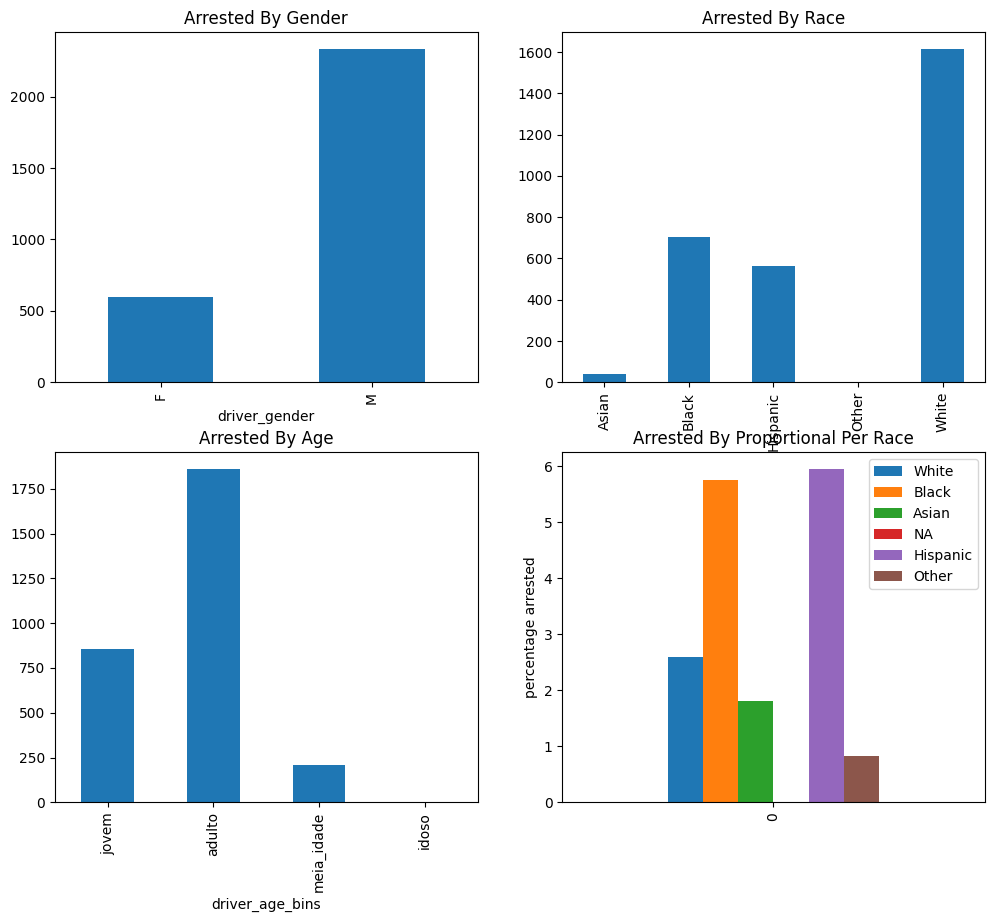

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2)
# change figure size
fig.set_size_inches(12, 10)

featured_df[featured_df.is_arrested == True].groupby("driver_gender")[
    "counter"
].count().plot(kind="bar", ax=axes[0, 0], title="Arrested By Gender")

featured_df[featured_df.is_arrested == True].groupby("driver_race")[
    "counter"
].count().plot(kind="bar", ax=axes[0, 1], title="Arrested By Race")

featured_df[featured_df.is_arrested == True].groupby("driver_age_bins")[
    "counter"
].count().plot(kind="bar", ax=axes[1, 0], title="Arrested By Age")

arrested_proportional_per_race_df.plot(
    kind="bar",
    ax=axes[1, 1],
    ylabel="percentage arrested",
    title="Arrested By Proportional Per Race",
)

In [17]:
p_being_arrested = (
    featured_df[featured_df.is_arrested == True].shape[0] / featured_df.shape[0]
)
p_being_arrested_and_black_or_hispanic = (
    featured_df[
        (featured_df.is_arrested == True) & (featured_df.is_black_or_hispanic == True)
    ].shape[0]
    / featured_df.shape[0]
)
p_being_black_or_hispanic = (
    featured_df[featured_df.is_black_or_hispanic == True].shape[0]
    / featured_df.shape[0]
)

p_being_arrested_given_black_or_hispanic = (
    p_being_arrested_and_black_or_hispanic / p_being_black_or_hispanic
)

print(f"Probability of being arrested: {p_being_arrested:.2f}%")
print(
    f"Probability of being arrested given the driver is black or hispanic: {p_being_arrested_given_black_or_hispanic:.2f}%"
)

Probability of being arrested: 0.03%
Probability of being arrested given the driver is black or hispanic: 0.06%


### Conclusions 📝

* The most occurred violation is speeding.
* The outcome level of the violations are very evenly distributed among violation types. With the exception of:
  * Motorist Assist/Courtesy - This is expected, since this is a courtesy.
  * Warrant - This is something to be investigated why the outcome level median is so high.

<Axes: title={'center': 'Violations Outcome Level Median'}, xlabel='violation_raw'>

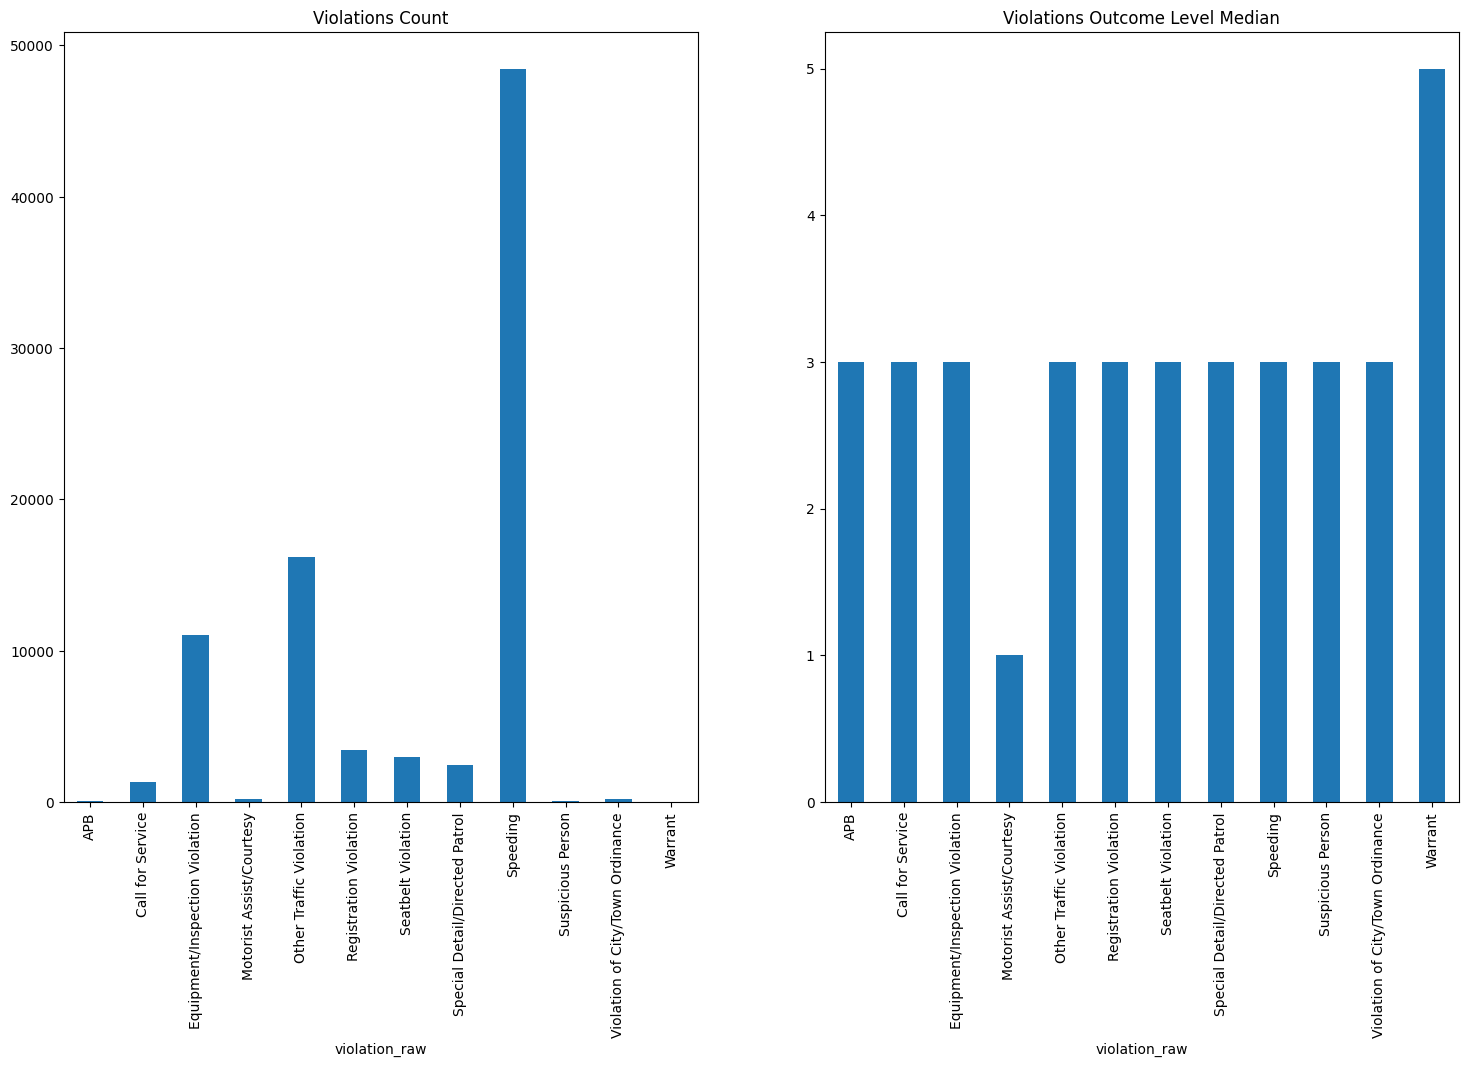

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2)
# change figure size
fig.set_size_inches(18, 10)


featured_df.groupby("violation_raw")["counter"].count().plot(
    kind="bar", title="Violations Count", ax=axes[0]
)


featured_df.groupby("violation_raw")["stop_outcome_level"].median().plot(
    kind="bar", title="Violations Outcome Level Median", ax=axes[1]
)

## More Exploratory Analysis 🧭🗺️

In [19]:
featured_df.describe()

,county_name,driver_age_raw,driver_age,stop_outcome_level,violation_level,proportional_stop_outcome,stop_time_discrete,counter
count,0.0,86414.000000,91741.000000,91741.000000,91741.000000,91741.000000,91741.000000,91741.0
mean,NaN,1970.491228,31.927448,2.860281,3.150445,1.540728,1194.606861,1.0
std,NaN,110.914909,14.793998,0.661906,1.966006,1.181678,651.307607,0.0
min,NaN,0.000000,0.000000,1.000000,1.000000,0.200000,0.000000,1.0
25%,NaN,1967.000000,22.000000,3.000000,1.000000,0.600000,810.000000,1.0
50%,NaN,1980.000000,29.000000,3.000000,5.000000,0.600000,1140.000000,1.0
75%,NaN,1987.000000,42.000000,3.000000,5.000000,3.000000,1635.000000,1.0
max,NaN,8801.000000,99.000000,5.000000,5.000000,5.000000,2359.000000,1.0


In [20]:
# Defining baseline features for comparison

baseline_features = [
    "is_arrested",
    "driver_race",
    "driver_gender",
    "stop_outcome_level",
    "violation_level",
    "search_conducted",
    "search_type",
    "drugs_related_stop",
    "stop_time_discrete_bins",
    "driver_age_bins",
]

In [21]:
def box_plot_by(df_, col):
    box = df_.copy()
    fig_size = (8, 10)

    plt.figure(figsize=fig_size)

    ax = box.boxplot(
        by=col,
        column="stop_outcome_level",
    )

    ax.set_xlabel("")
    ax.set_ylabel("Stop Outcome Level (arrested, warning, citation...)")
    plt.suptitle("Outcome Level by " + col)

    bx = box.boxplot(
        by=col,
        column="violation_level",
    )
    bx.set_xlabel("")
    bx.set_ylabel("Violation Level (Speed, moving violation, ....)")
    plt.suptitle("Violation Level by " + col)

## Correlations 📈 

### Mutual Information

In [22]:
X = featured_df.copy()
X = X[baseline_features]
y = X.pop("stop_outcome_level")

In [23]:
# label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

X["stop_time_discrete_bins"], _ = X["stop_time_discrete_bins"].factorize()
X["driver_age_bins"], _ = X["driver_age_bins"].factorize()

discrete_features = X.dtypes == int

display(X.head())
display(X["stop_time_discrete_bins"].dtype)

,is_arrested,driver_race,driver_gender,violation_level,search_conducted,search_type,drugs_related_stop,stop_time_discrete_bins,driver_age_bins
0,False,0,0,5,False,0,False,0,0
1,False,0,0,5,False,0,False,1,1
2,False,0,0,5,False,0,False,2,1
3,True,0,0,1,False,0,False,3,0
4,False,0,1,5,False,0,False,1,0


dtype('int64')

In [24]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [25]:
from sklearn.feature_selection import mutual_info_regression


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(
        X,
        y,
        discrete_features=discrete_features,
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show few features with their scores

driver_race         0.201360
violation_level     0.082461
search_conducted    0.021986
Name: MI Scores, dtype: float64

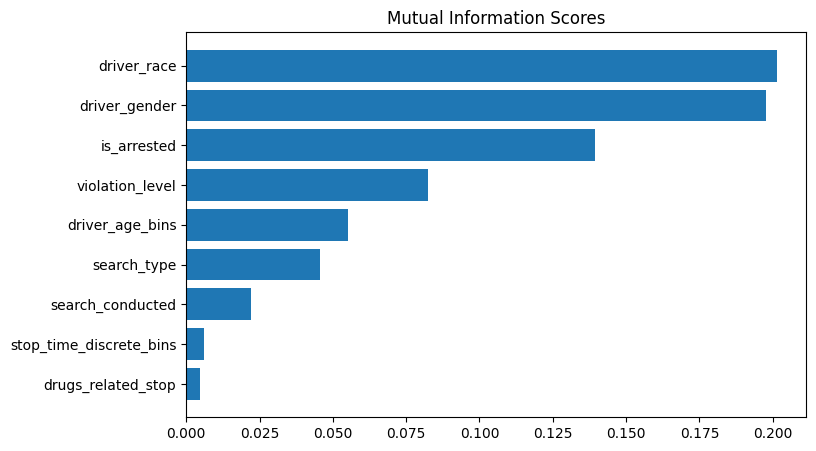

In [26]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

<Axes: >

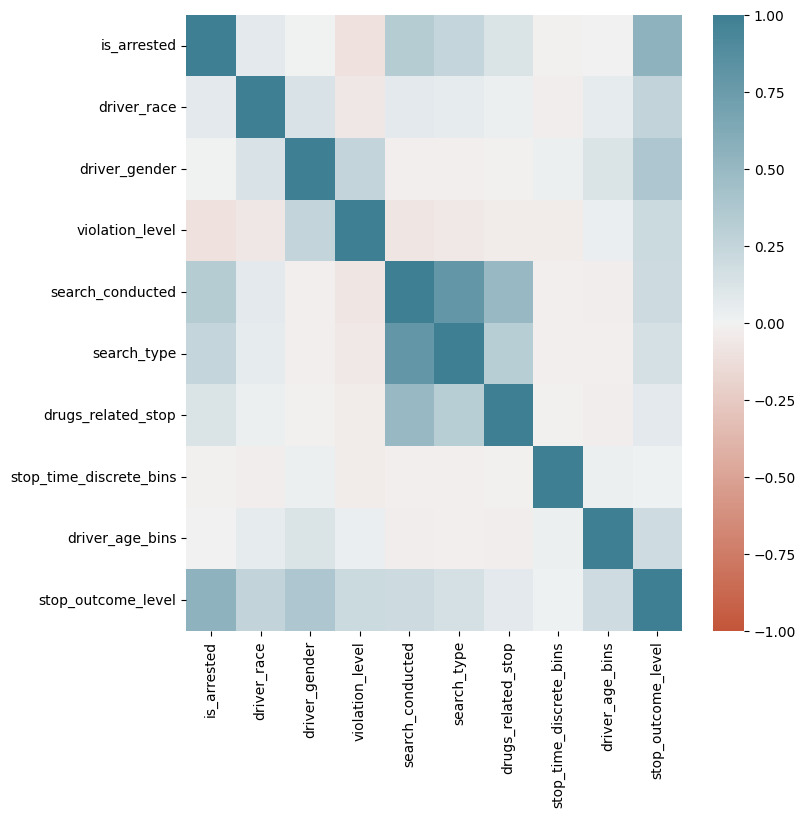

In [27]:
# Correlationa

X_y = X.copy()
X_y["stop_outcome_level"] = y

plt.rcParams["figure.figsize"] = (8, 8)
sns.heatmap(
    X_y.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True)
)

## Using Decision Tree 🌲🌳

Using decision tree to understand how the most important feature values correlates with the stop outcome level.

In [28]:
from sklearn import tree
from matplotlib import pyplot as plt

selected_features = [
    "driver_race",
    "driver_gender",
    "driver_age_bins",
    "violation_level",
    # "is_black_or_hispanic",
]
X_tree = featured_df.copy()
y_tree = X_tree.pop("is_arrested")
X_tree = pd.get_dummies(X_tree[selected_features], drop_first=False)

display(print(f"Y => {y_tree.hasnans}"))

clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_tree, y_tree)

Y => False


None

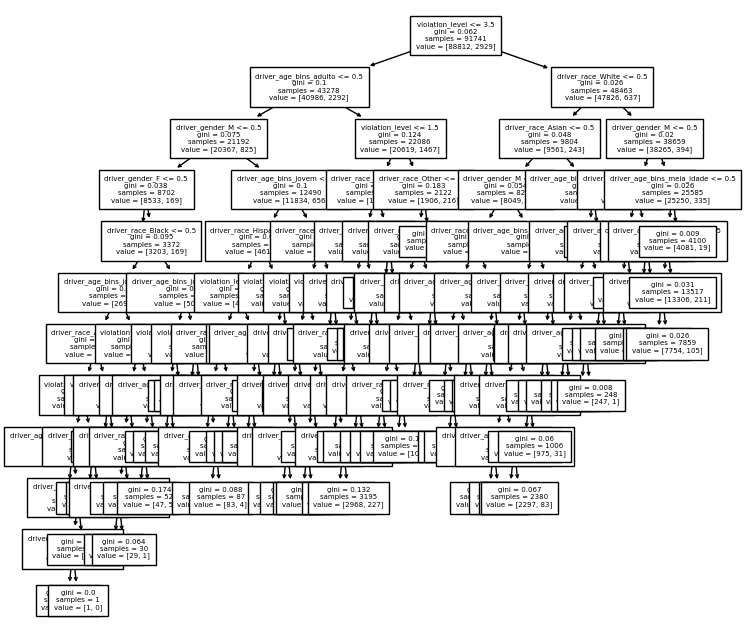

<Figure size 1000x1000 with 0 Axes>

In [29]:
# plt.rcParams["figure.figsize"] = (30,30)
# plt.rcParams["figure.figsize"] = (10,10)
tree.plot_tree(clf, feature_names=X_tree.columns, fontsize=5)
plt.figure(dpi=100, figsize=(10, 10))
plt.show()

## Linear Regression Coeficient Analysis 📈🧪

In [30]:
# creating lm dataset
X_lm = featured_df.copy()
y_lm = X_lm.pop("stop_outcome_level")

# selecting lm features
lm_features = [
    "driver_race",
    "driver_gender",
    "driver_age_bins",
    "violation_level",
    "search_conducted",
    "drugs_related_stop",
]

for bool_col in ["search_conducted", "drugs_related_stop"]:
    X_lm[bool_col] = X_lm[bool_col].astype("str")

# getting categorical features dummies
X_lm = pd.get_dummies(X_lm[lm_features], drop_first=False)

X_lm.head()

,violation_level,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White,driver_gender_F,driver_gender_M,driver_age_bins_jovem,driver_age_bins_adulto,driver_age_bins_meia_idade,driver_age_bins_idoso,search_conducted_False,search_conducted_True,drugs_related_stop_False,drugs_related_stop_True
0,5,False,False,False,False,True,False,True,True,False,False,False,True,False,True,False
1,5,False,False,False,False,True,False,True,False,True,False,False,True,False,True,False
2,5,False,False,False,False,True,False,True,False,True,False,False,True,False,True,False
3,1,False,False,False,False,True,False,True,True,False,False,False,True,False,True,False
4,5,False,False,False,False,True,True,False,True,False,False,False,True,False,True,False


In [31]:
from sklearn.linear_model import LinearRegression

police_stop_lm = LinearRegression()
police_stop_lm.fit(X_lm, y_lm)

print(f"Intercept: {police_stop_lm.intercept_:.3f}")
print(f"Coefficients: ")
for name, coef in zip(X_lm.columns, police_stop_lm.coef_):
    print(f" {name}: {coef}")

Intercept: -14572561076.186
Coefficients: 
 violation_level: 0.014661701636678804
 driver_race_Asian: 1.4381177667984368
 driver_race_Black: 1.4552702406044604
 driver_race_Hispanic: 1.4618536787342788
 driver_race_Other: 1.375729013586228
 driver_race_White: 1.4331522356985946
 driver_gender_F: 0.4631743710888586
 driver_gender_M: 0.4848465566088227
 driver_age_bins_jovem: 79968491.21609595
 driver_age_bins_adulto: 79968491.2243004
 driver_age_bins_meia_idade: 79968491.1932562
 driver_age_bins_idoso: 79968491.04616134
 search_conducted_False: 1407578695.0263271
 search_conducted_True: 1407578695.691715
 drugs_related_stop_False: 13085013890.928486
 drugs_related_stop_True: 13085013890.69417


In [32]:
from statsmodels.regression.linear_model import OLS

model = OLS(y_lm, X_lm.astype(float))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     stop_outcome_level   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     3629.
Date:                Mon, 10 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:55:32   Log-Likelihood:                -72101.
No. Observations:               91741   AIC:                         1.442e+05
Df Residuals:                   91726   BIC:                         1.444e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
violation_level                0.0156      0.001     13.829      0.000       0.013       0.018
driver_race_Asian              1.4328      0.376      3.813      0.000       0.696       2.169
driver_race_Black              1.4585      0.376      3.883      0.000       0.722       2.195
driver_race_Hispanic           1.4682      0.376      3.908      0.000       0.732       2.204
driver_race_Other              1.3801      0.377      3.659      0.000       0.641       2.119
driver_race_White              1.4318      0.376      3.812      0.000       0.696       2.168
driver_gender_F                0.4631      0.376      1.233      0.217      -0.273       1.199
driver_gender_M                0.4847      0.376      1.291      0.197      -0.251       1.221
driver_age_bins_jovem      -6.292e+09    8.5e+09     -0.740      0.459    -2.3e+10    1.04e+10
driver_age_bins_adulto     -6.292e+09    8.5e+09     -0.740      0.459    -2.3e+10    1.04e+10
driver_age_bins_meia_idade -6.292e+09    8.5e+09     -0.740      0.459    -2.3e+10    1.04e+10
driver_age_bins_idoso      -6.292e+09    8.5e+09     -0.740      0.459    -2.3e+10    1.04e+10
search_conducted_False       1.73e+11   9.02e+10      1.917      0.055   -3.88e+09     3.5e+11
search_conducted_True        1.73e+11   9.02e+10      1.917      0.055   -3.88e+09     3.5e+11
drugs_related_stop_False   -1.667e+11   8.71e+10     -1.912      0.056   -3.37e+11    4.15e+09
drugs_related_stop_True    -1.667e+11   8.71e+10     -1.912      0.056   -3.37e+11    4.15e+09
==============================================================================
Omnibus:                    17576.968   Durbin-Watson:                   1.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           449533.957
Skew:                           0.251   Prob(JB):                         0.00
Kurtosis:                      13.833   Cond. No.                     4.10e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.97e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## K-Means To Create Clusters ☯️

In [33]:
X_kmeans = X.copy()

X_kmeans.head()

,is_arrested,driver_race,driver_gender,violation_level,search_conducted,search_type,drugs_related_stop,stop_time_discrete_bins,driver_age_bins
0,False,0,0,5,False,0,False,0,0
1,False,0,0,5,False,0,False,1,1
2,False,0,0,5,False,0,False,2,1
3,True,0,0,1,False,0,False,3,0
4,False,0,1,5,False,0,False,1,0


In [34]:
from sklearn.cluster import KMeans

n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters)
X_kmeans["cluster"] = kmeans.fit_predict(X)
X_kmeans["cluster"] = X_kmeans["cluster"].astype("category")

X_kmeans.head()

/Users/guilhermeleonardonunes/Mestrado/periodo_2/masters-data-science/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,is_arrested,driver_race,driver_gender,violation_level,search_conducted,search_type,drugs_related_stop,stop_time_discrete_bins,driver_age_bins,cluster
0,False,0,0,5,False,0,False,0,0,0
1,False,0,0,5,False,0,False,1,1,0
2,False,0,0,5,False,0,False,2,1,2
3,True,0,0,1,False,0,False,3,0,1
4,False,0,1,5,False,0,False,1,0,0


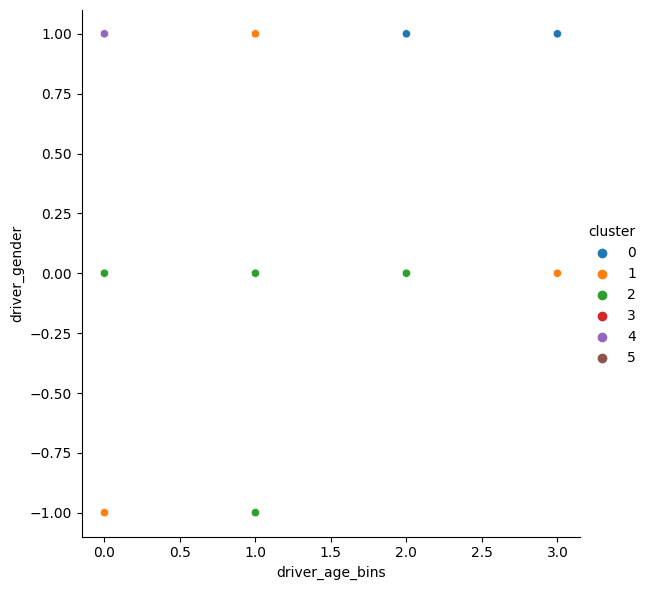

In [35]:
sns.relplot(
    x="driver_age_bins",
    y="driver_gender",
    hue="cluster",
    data=X_kmeans,
    height=n_clusters,
)

## Hypothesis